
Import lib
---



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ast
import numpy as np
import torch.utils.data as data


Cuda check
---



In [2]:
# Kiểm tra xem CUDA có khả dụng không
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Input info
---





In [3]:
# Cấu hình các thông số huấn luyện
num_classes = 36  # Số lượng lớp đầu ra
num_sensors =5
sequence_length=10
batch_size = 32

Label mapping
---



In [22]:
# Tạo label map từ chuỗi nhãn sang chỉ mục nguyên
label_map = {}
index = 0
for i in range(1, 10):
    for j in range(1, 5):
        # Biểu diễn vị trí của mỗi ô trong lưới 9x4 dưới dạng chuỗi
        label = f"{i}{j}"
        # Ánh xạ chuỗi nhãn sang chỉ mục nguyên
        label_map[label] = index
        index += 1

# In label map để kiểm tra
print(label_map)


# Hàm chuyển đổi chuỗi nhãn thành chỉ mục nguyên
def label_to_index(labels):
    # Chuyển đổi tensor labels về list giá trị của nó
    labels_list = [str(label.item()) for label in labels]
    # Sử dụng list giá trị để truy cập từ điển ánh xạ
    return torch.tensor([label_map[label] for label in labels_list])

# Tạo từ điển ánh xạ từ chỉ mục lớp sang nhãn
index_to_label = {index: label for label, index in label_map.items()}

# Hàm chuyển đổi chỉ mục thành nhãn
def index_to_label_func(index):
    return index_to_label[index]


{'11': 0, '12': 1, '13': 2, '14': 3, '21': 4, '22': 5, '23': 6, '24': 7, '31': 8, '32': 9, '33': 10, '34': 11, '41': 12, '42': 13, '43': 14, '44': 15, '51': 16, '52': 17, '53': 18, '54': 19, '61': 20, '62': 21, '63': 22, '64': 23, '71': 24, '72': 25, '73': 26, '74': 27, '81': 28, '82': 29, '83': 30, '84': 31, '91': 32, '92': 33, '93': 34, '94': 35}



Import dataset and visualize
---



In [5]:
# # Khởi tạo dữ liệu giả định và di chuyển nó lên GPU (nếu có sẵn)
# num_samples = 1000
# sequence_length = 100
# X_train = torch.randn(num_samples, num_sensors, sequence_length).to(device)
# y_train = torch.randint(0, num_classes, (num_samples,)).to(device)
# print("Kích thước của x_train:", X_train.shape)
# print("Kích thước của y_train:", y_train.shape)

# #luu du lieu tao duoi dang csv
# import pandas as pd

# # Chuyển đổi tensors PyTorch thành mảng NumPy
# X_train_numpy = X_train.cpu().numpy()
# y_train_numpy = y_train.cpu().numpy()

# # Tạo DataFrame từ dữ liệu
# data = {'x' + str(i+1): X_train_numpy[:, i, :].tolist() for i in range(num_sensors)}
# data['y'] = y_train_numpy.tolist()
# df = pd.DataFrame(data)

# # Lưu DataFrame vào file CSV
# df.to_csv('data.csv', index=False)

# print("File CSV đã được lưu.")
# X_train[0]


In [6]:
#Load du lieu x y tu file csv


# Đọc dữ liệu từ file CSV vào DataFrame
df = pd.read_csv('data.csv')

# Tách cột 'x' và 'y'
x_data = df[['x1', 'x2', 'x3', 'x4', 'x5']]  # Chọn các cột 'x1', 'x2', 'x3', 'x4', 'x5' làm đặc trưng
y_data = df['y']  # Chọn cột 'y' làm nhãn

# Chuyển đổi dữ liệu 'x' thành tensors PyTorch
x_train = []
for _, row in x_data.iterrows():
    x_values = [ast.literal_eval(val) for val in row.values]  # Phân tích các giá trị từ chuỗi thành danh sách
    x_train.append(torch.tensor(x_values, dtype=torch.float32))
X_train = torch.stack(x_train).to(device)
# Chuyển đổi dữ liệu 'y' thành tensors PyTorch
y_train = torch.tensor(y_data.values, dtype=torch.long).to(device)

# Kiểm tra kích thước của tensors
print("Kích thước của x_train:", X_train.shape)
print("Kích thước của y_train:", y_train.shape)

num_samples = y_train.shape[0]

# X_train[0]

Kích thước của x_train: torch.Size([25840, 5, 10])
Kích thước của y_train: torch.Size([25840])


In [7]:
# # Chọn một mẫu ngẫu nhiên từ tập dữ liệu đào tạo
# sample_index = np.random.randint(0,num_samples)

# # Lấy dữ liệu và nhãn của mẫu đã chọn
# sample_data = X_train[sample_index].cpu().numpy()  # Chuyển dữ liệu về CPU và numpy array
# sample_label = y_train[sample_index].item()

# # Vẽ dữ liệu từng cảm biến
# plt.figure(figsize=(10, 6))
# # Plot data for each sensor
# for i in range(num_sensors):
#         plt.plot(sample_data[i], label=f"Sensor {i+1}")

# # # Check if the first dimension has more than one element
# # if sample_data.shape[0] > 1:
# #     # Plot data for each sensor
# #     for i in range(num_sensors):
# #         plt.plot(sample_data[i], label=f"Sensor {i+1}")
# # else:
# #     # If only one element, plot directly
# #     plt.plot(sample_data[0], label="Sensor 1")

# plt.title('Sensor Data')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

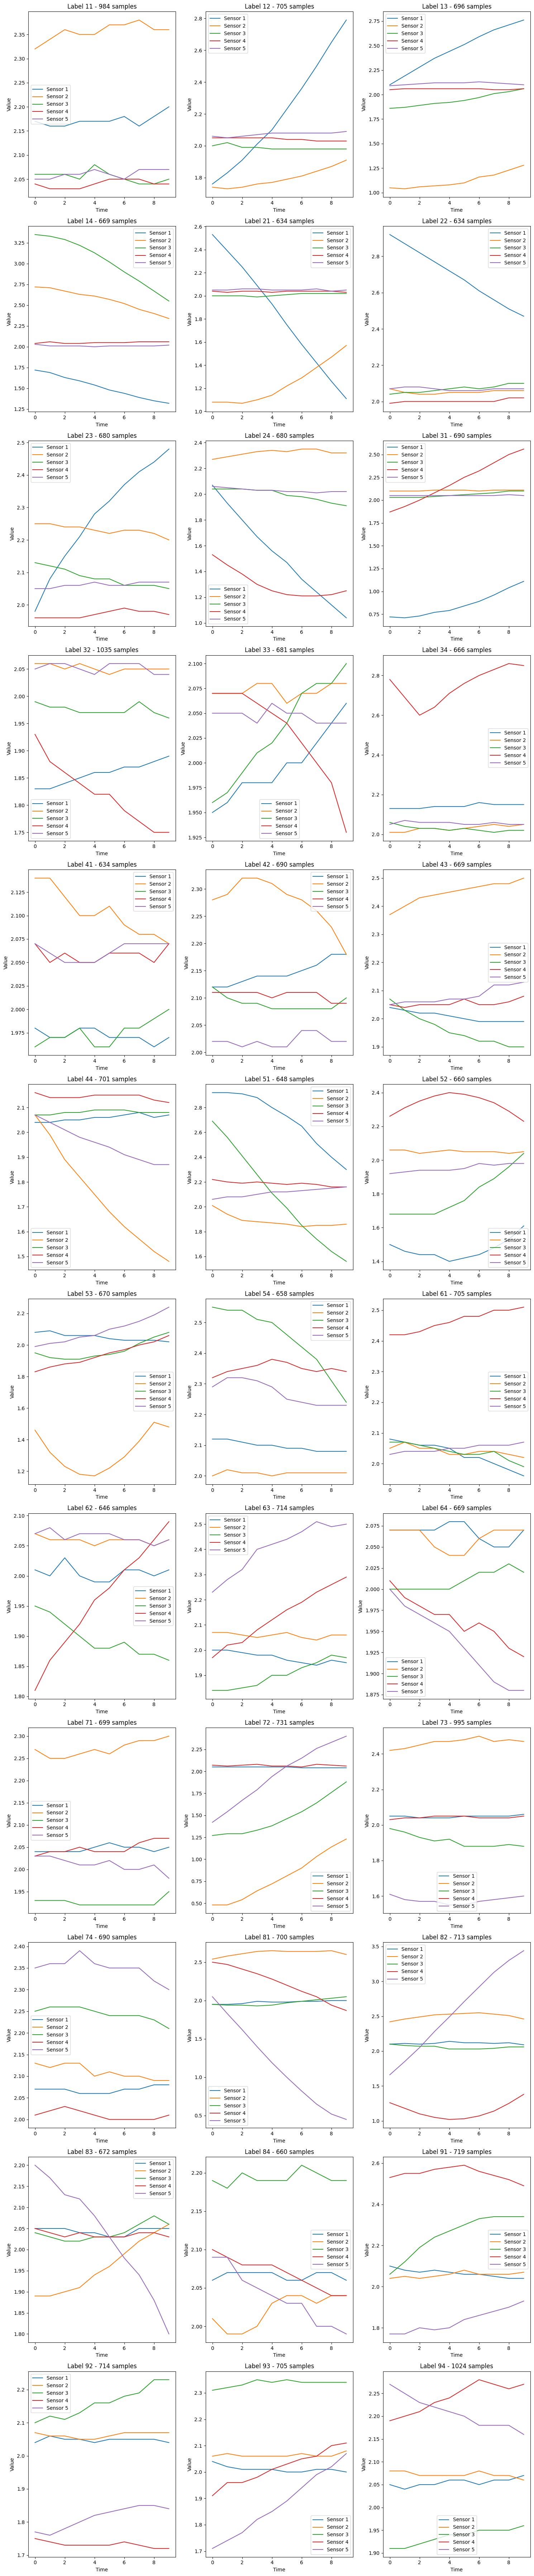

In [8]:
# Chọn một mẫu ngẫu nhiên mỗi nhãn từ tập dữ liệu đào tạo để vẽ và note lại số lượng sample mỗi nhãn

# Giả sử X_train và y_train là các tensor PyTorch chứa dữ liệu và nhãn tương ứng
# num_samples là tổng số mẫu trong tập dữ liệu
# num_sensors là số lượng cảm biến

# Số lượng nhãn
unique_labels = torch.unique(y_train)
num_labels = len(unique_labels)

# Tạo một dictionary để lưu trữ mẫu ngẫu nhiên cho mỗi nhãn
samples_per_label = {}

# Chọn ngẫu nhiên một mẫu cho mỗi nhãn
for label in unique_labels:
    # Lấy các chỉ số của các mẫu có nhãn hiện tại
    indices = (y_train == label).nonzero(as_tuple=True)[0]
    # Chọn ngẫu nhiên một chỉ số từ các chỉ số này
    sample_index = np.random.choice(indices.cpu().numpy())
    # Lưu trữ dữ liệu và nhãn của mẫu đã chọn
    sample_data = X_train[sample_index].cpu().numpy()
    sample_label = y_train[sample_index].item()
    samples_per_label[sample_label] = (sample_data, len(indices))

# Xác định số hàng cần thiết dựa trên số nhãn và số cột (3)
num_cols = 3
num_rows = int(np.ceil(num_labels / num_cols))

# Vẽ dữ liệu của từng mẫu đã chọn
plt.figure(figsize=(15, num_rows * 6))

for idx, (label, (data, count)) in enumerate(samples_per_label.items()):
    plt.subplot(num_rows, num_cols, idx + 1)
    for i in range(num_sensors):
        plt.plot(data[i], label=f"Sensor {i+1}")
    plt.title(f'Label {label} - {count} samples')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()


Splitting dataset
---




In [9]:
import torch.utils.data as data
# Tổng số mẫu
total_samples = len(X_train)

# Tính số lượng mẫu cho tập huấn luyện và tập kiểm tra
train_size = int(0.8 * total_samples)  # 80% cho tập huấn luyện
test_size = total_samples - train_size  # 20% cho tập kiểm tra

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_dataset, test_dataset = data.random_split(torch.utils.data.TensorDataset(X_train, y_train), [train_size, test_size])

# Khởi tạo DataLoader cho cả tập huấn luyện và tập kiểm tra
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(train_size,test_size)

20672 5168


Model definition and fastforward
---



In [10]:
# Định nghĩa mô hình CNN 1D
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(512)
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.batch_norm5 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.3)
        self.padding = nn.ConstantPad1d((0, 1), value=0)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1 )
        self.fc = nn.Linear(1024*sequence_length, num_classes)  # Chỉnh kích thước đầu vào của fully connected

    # def forward(self, x):
    #     x = torch.relu(self.batch_norm1(self.conv1(x)))
    #     print(f'Kich thuoc x sau conv1 {x.shape}')
    #     x = torch.relu(self.batch_norm2(self.conv2(x)))
    #     print(f'Kich thuoc x sau conv2 {x.shape}')
    #     x = torch.relu(self.batch_norm3(self.conv3(x)))
    #     print(f'Kich thuoc x sau conv3 {x.shape}')
    #     x = torch.relu(self.batch_norm4(self.conv4(x)))
    #     print(f'Kich thuoc x sau conv4 {x.shape}')
    #     x = torch.relu(self.batch_norm5(self.conv5(x)))
    #     print(f'Kich thuoc x sau conv5 {x.shape}')
    #     # x = torch.max_pool1d(x, kernel_size=2,)
    #     x = self.padding(x)
    #     print(f'Kich thuoc x sau padding {x.shape}')
    #     x = self.maxpool(x)
    #     print(f'Kich thuoc x sau maxpol {x.shape}')
    #     x = self.dropout(x)
    #     print(f'Kich thuoc x sau dropout {x.shape}')
    #     x = x.view(x.size(0), -1)  # Kích thước phẳng (flattening)
    #     print(f'Kich thuoc x sau x.view {x.shape}')
    #     x = self.fc(x)
    #     return x
# # Khởi tạo mô hình
# input_size = num_sensors  # Số lượng cảm biến
# model = CNN1D(input_size=input_size, num_classes=num_classes).to(device)

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    # def forward(self, x):
    #     # Khởi tạo hidden state và cell state ban đầu
    #     h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    #     c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    #     # Đi qua LSTM
    #     out, _ = self.lstm(x, (h0, c0))

    #     # Chỉ lấy thông tin từ timestep cuối cùng
    #     out = out[:, -1, :]

    #     # Đi qua tầng fully connected
    #     out = self.fc(out)

    #     # Áp dụng hàm kích hoạt ReLU
    #     out = self.relu(out)
    #     return out

# # Khởi tạo mô hình
# input_size = 100  # Mỗi chuỗi kênh đầu vào có kích thước 1x100
# hidden_size = 1024  # Số hidden unit
# num_layers = 2  # Số lớp LSTM
# num_classes = 36  # Số lớp đầu ra
# dropout_rate = 0.3  # Tỉ lệ dropout

# model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout_rate)

# # Kiểm tra mô hình với batch size là 32, 1024 chuỗi, mỗi chuỗi 100 timesteps
# test_input = torch.randn(32, 1024, 100)  # Batch size là 32
# output = model(test_input)
# print(output.shape)  # Kết quả đầu ra sẽ có kích thước [32, 36]

In [12]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNLSTM, self).__init__()
        # Khai báo phần CNN
        self.cnn = CNN1D(input_size=input_size, num_classes=num_classes)
        # Khai báo phần LSTM
        self.lstm = LSTMModel(input_size=1024, hidden_size=1024, num_layers=2, num_classes=num_classes, dropout_rate=0.3)

    def forward(self, x):
        batch_size, _, _ = x.shape
        # Qua CNN
        x = self.cnn.conv1(x)
        x = torch.relu(self.cnn.batch_norm1(x))
        x = self.cnn.conv2(x)
        x = torch.relu(self.cnn.batch_norm2(x))
        x = self.cnn.conv3(x)
        x = torch.relu(self.cnn.batch_norm3(x))
        x = self.cnn.conv5(x)
        x = torch.relu(self.cnn.batch_norm5(x))
        x = self.cnn.padding(x)
        x = self.cnn.maxpool(x)
        x = self.cnn.dropout(x)
        # print(f"kich thuoc x sau dropout: {x.shape}")
        # print(x)
        # Thay đổi hình dạng để phù hợp với đầu vào của LSTM
        x = x.transpose(1, 2)  # Transpose để phù hợp chiều với LSTM
        x = x.contiguous().view(batch_size, -1, 1024)  # Sắp xếp lại để có kích thước phù hợp cho LSTM
        # print(f"kich thuoc x sau contiguous: {x.shape}")
        # print(x)

        # Qua LSTM
        # x = self.lstm(x)

        # Khởi tạo hidden state và cell state ban đầu
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        # Đi qua LSTM
        x, _ = self.lstm.lstm(x, (h0, c0))
        # print(f"kich thuoc x sau lstm: {x.shape}")
        # print(x)
        # Chỉ lấy thông tin từ timestep cuối cùng
        x = x[:, -1, :]

        # print(f"kich thuoc x sau timestep cuoi: {x.shape}")
        # print(x)

        # Đi qua tầng fully connected
        x = self.lstm.fc(x)
        # Áp dụng hàm kích hoạt ReLU
        x = self.lstm.relu(x)
        # print(f"kich thuoc x sau fc: {x.shape}")
        # print(x)

        return x
# Khởi tạo mô hình
input_size = num_sensors  # Số lượng cảm biến
model = CNNLSTM(input_size=input_size, num_classes=num_classes).to(device)


Import trained model
---



In [13]:
# Đường dẫn đến tệp tin chứa trạng thái của mô hình
model_file_path = 'my_model.pth'

# Kiểm tra xem tệp tin tồn tại hay không
if os.path.isfile(model_file_path):
    # Nếu tệp tin tồn tại, tải trạng thái của mô hình từ tệp tin đã lưu
    if device == "cuda":
        model.load_state_dict(torch.load(model_file_path))
    else:
        model.load_state_dict(torch.load(model_file_path, map_location=torch.device('cpu')))
    print("Đã tải mô hình từ tệp tin đã lưu.")
else:
    print("Không tìm thấy tệp tin của mô hình.")

Đã tải mô hình từ tệp tin đã lưu.


Training variable assign
---



In [ ]:
# Huấn luyện mô hình
num_epochs = 100
learning_rate = 0.0001
weight_decay = 0.0001  # L2 regularization

# Khởi tạo optimizer và loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


Trainning phase
---



In [ ]:
train_losses=[]
# Huấn luyện mô hình
for epoch in range(num_epochs):
    model.train()  # Chuyển sang chế độ huấn luyện
    running_loss = 0.0
    for inputs, labels_str in train_loader:
        inputs, labels_str = inputs.to(device), labels_str

        # Chuyển đổi nhãn thành chỉ mục nguyên
        labels = label_to_index(labels_str).to(device)

        # Feedforward
        outputs = model(inputs)

        # Tính loss và backward
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Lưu trữ loss cho epoch hiện tại
    train_losses.append(running_loss / (num_samples / batch_size))

    if (epoch+1)%10==0:
      # Lưu trạng thái của mô hình vào một tệp tin
      torch.save(model.state_dict(), model_file_path)
      print(f'Da luu model: {model_file_path}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training finished!')


Epoch [1/100], Loss: 2.2024
Epoch [2/100], Loss: 2.1232
Epoch [3/100], Loss: 1.5575
Epoch [4/100], Loss: 1.2358
Epoch [5/100], Loss: 1.0534
Epoch [6/100], Loss: 1.1794
Epoch [7/100], Loss: 0.8808
Epoch [8/100], Loss: 0.5179
Epoch [9/100], Loss: 0.6379
Da luu model: my_model.pth
Epoch [10/100], Loss: 0.3064
Epoch [11/100], Loss: 0.4685
Epoch [12/100], Loss: 0.5147
Epoch [13/100], Loss: 0.5622
Epoch [14/100], Loss: 0.2994
Epoch [15/100], Loss: 0.3330
Epoch [16/100], Loss: 0.2145
Epoch [17/100], Loss: 0.7189
Epoch [18/100], Loss: 0.3024
Epoch [19/100], Loss: 0.6775
Da luu model: my_model.pth
Epoch [20/100], Loss: 0.5829
Epoch [21/100], Loss: 0.5021
Epoch [22/100], Loss: 0.5969
Epoch [23/100], Loss: 0.1617
Epoch [24/100], Loss: 0.0521
Epoch [25/100], Loss: 0.2240
Epoch [26/100], Loss: 0.3676
Epoch [27/100], Loss: 0.1743
Epoch [28/100], Loss: 0.2745
Epoch [29/100], Loss: 0.3018
Da luu model: my_model.pth
Epoch [30/100], Loss: 0.6049
Epoch [31/100], Loss: 0.2932
Epoch [32/100], Loss: 0.3069


In [ ]:
print(outputs.shape)

torch.Size([32, 36])


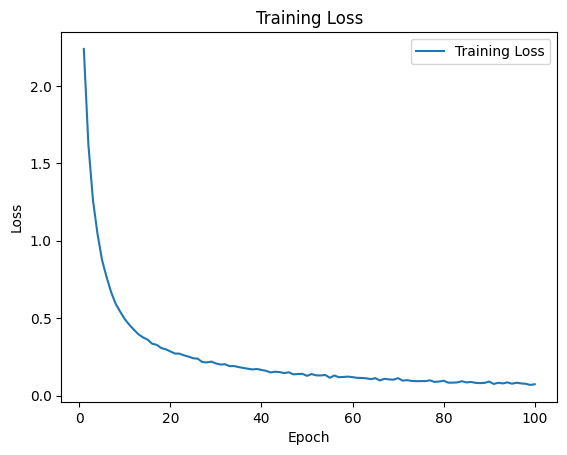

In [ ]:
# Vẽ đồ thị loss qua các epoch
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Result evaluation
---



In [38]:
import torch.utils.data as data
from collections import defaultdict
TP = 0
number_sample = 0
wrong_predictions = defaultdict(lambda: {"predicted_labels": [], "count": 0})  # Tạo một từ điển để tổng hợp số lượng mẫu mỗi nhãn được dự đoán sai

# Tạo các từ điển để lưu trữ số lượng TP, FP, FN cho mỗi nhãn
TP_dict = defaultdict(int)
FP_dict = defaultdict(int)
FN_dict = defaultdict(int)
total_samples_per_label = defaultdict(int)

model.eval()
# Duyệt qua các mẫu trong test_loader
for input_sequence, label in test_loader:
    # Dự đoán đầu ra cho mỗi batch trong test_loader
    with torch.no_grad():
        output = model(input_sequence.to(device))

    # Xử lý đầu ra để có được dự đoán cuối cùng
    predicted_class = torch.argmax(output, dim=1)
    predicted_labels = [index_to_label_func(pred.item()) for pred in predicted_class]

    number_sample += len(label)

    for i, true_label in enumerate(label):
        true_label_str = str(true_label.item())
        total_samples_per_label[true_label_str] += 1

        predicted_label = predicted_labels[i]

        if true_label_str == predicted_label:
            TP += 1
            TP_dict[true_label_str] += 1
        else:
            FP_dict[predicted_label] += 1
            FN_dict[true_label_str] += 1
            wrong_predictions[true_label_str]["predicted_labels"].append(predicted_label)
            wrong_predictions[true_label_str]["count"] += 1

Acc = TP / number_sample
print("Độ chính xác:", Acc)
print("Tổng hợp số lượng mẫu mỗi nhãn và nhãn mà model dự đoán sai theo thứ tự của nhãn:")

# Sắp xếp từ điển theo thứ tự của các nhãn
sorted_wrong_predictions = dict(sorted(wrong_predictions.items()))

# In ra thông tin chi tiết về số lượng mẫu mỗi nhãn và nhãn mà model dự đoán sai
for true_label, info in sorted_wrong_predictions.items():
    total_samples = total_samples_per_label[true_label]
    print(f"Nhãn: {true_label} - Số lượng mẫu: {total_samples} - Nhãn mà model dự đoán sai: {info['predicted_labels']} - Số lần dự đoán sai: {info['count']}")

# Tính toán và in F1 score cho mỗi nhãn
print("F1 score cho mỗi nhãn:")
for label in set(TP_dict.keys()).union(set(FP_dict.keys())).union(set(FN_dict.keys())):
    TP = TP_dict[label]
    FP = FP_dict[label]
    FN = FN_dict[label]

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # print(f"Nhãn: {label} - Precision: {precision:.2f} - Recall: {recall:.2f} - F1 score: {f1_score:.2f}")

# Tính F1 score trung bình (macro F1 score)
all_labels = set(TP_dict.keys()).union(set(FP_dict.keys())).union(set(FN_dict.keys()))
macro_f1_score = sum(
    (2 * (TP_dict[label] / (TP_dict[label] + FP_dict[label]) if (TP_dict[label] + FP_dict[label]) > 0 else 0) *
     (TP_dict[label] / (TP_dict[label] + FN_dict[label]) if (TP_dict[label] + FN_dict[label]) > 0 else 0)) /
    ((TP_dict[label] / (TP_dict[label] + FP_dict[label]) if (TP_dict[label] + FP_dict[label]) > 0 else 0) +
     (TP_dict[label] / (TP_dict[label] + FN_dict[label]) if (TP_dict[label] + FN_dict[label]) > 0 else 0)) if
    ((TP_dict[label] / (TP_dict[label] + FP_dict[label]) if (TP_dict[label] + FP_dict[label]) > 0 else 0) +
     (TP_dict[label] / (TP_dict[label] + FN_dict[label]) if (TP_dict[label] + FN_dict[label]) > 0 else 0)) > 0 else 0
    for label in all_labels
) / len(all_labels)

print(macro_f1_score)

Độ chính xác: 0.9740712074303406
Tổng hợp số lượng mẫu mỗi nhãn và nhãn mà model dự đoán sai theo thứ tự của nhãn:
Nhãn: 11 - Số lượng mẫu: 207 - Nhãn mà model dự đoán sai: ['13', '21', '13', '13'] - Số lần dự đoán sai: 4
Nhãn: 12 - Số lượng mẫu: 140 - Nhãn mà model dự đoán sai: ['11', '11', '14', '22', '11', '13', '11', '11', '13', '11', '22'] - Số lần dự đoán sai: 11
Nhãn: 13 - Số lượng mẫu: 154 - Nhãn mà model dự đoán sai: ['22', '11', '11', '11', '14', '12', '22', '12', '12'] - Số lần dự đoán sai: 9
Nhãn: 14 - Số lượng mẫu: 104 - Nhãn mà model dự đoán sai: ['11', '11'] - Số lần dự đoán sai: 2
Nhãn: 21 - Số lượng mẫu: 134 - Nhãn mà model dự đoán sai: ['12', '41'] - Số lần dự đoán sai: 2
Nhãn: 22 - Số lượng mẫu: 141 - Nhãn mà model dự đoán sai: ['11', '21', '23', '32', '24'] - Số lần dự đoán sai: 5
Nhãn: 23 - Số lượng mẫu: 150 - Nhãn mà model dự đoán sai: ['22', '14', '12', '22'] - Số lần dự đoán sai: 4
Nhãn: 24 - Số lượng mẫu: 135 - Nhãn mà model dự đoán sai: ['22'] - Số lần dự đoán


Testing
---



In [ ]:
# # Giả sử model đã được huấn luyện và có tên là model

# # Chuỗi đầu vào
# input_sequence = torch.randn(1, 5, 10)  # Giả sử kích thước của chuỗi là (1, 5, 100)

# # Vẽ dữ liệu từng cảm biến
# plt.figure(figsize=(10, 6))
# for i in range(num_sensors):
#     plt.plot(input_sequence[0][i], label=f"Sensor {i+1}")
# plt.title('Sensor Data')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Dự đoán đầu ra
# with torch.no_grad():
#     output = model(input_sequence.to(device))

# # Xử lý đầu ra để có được dự đoán cuối cùng
# predicted_class = torch.argmax(output, dim=1)
# predicted_label = index_to_label_func(predicted_class.item())

# print("Dự đoán cuối cùng:", predicted_label)

Nhãn của mẫu: 63


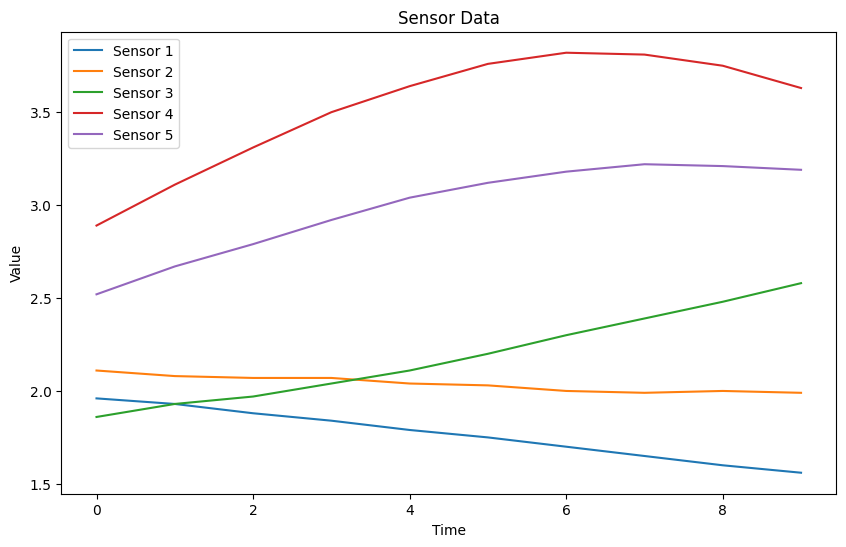

Dự đoán cuối cùng: 63


In [ ]:
# Tạo DataLoader từ test_dataset với batch_size=1 và shuffle=True
data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Lấy một mẫu ngẫu nhiên từ DataLoader
for input_sequence, label in data_loader:
    # In nhãn của mẫu
    print("Nhãn của mẫu:", label.item())

    # Vẽ dữ liệu từng cảm biến
    plt.figure(figsize=(10, 6))
    for i in range(num_sensors):
        plt.plot(input_sequence[0][i].cpu(), label=f"Sensor {i+1}")
    plt.title('Sensor Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Dự đoán đầu ra cho mẫu đã lấy ngẫu nhiên
    with torch.no_grad():
        output = model(input_sequence.to(device))

    # Xử lý đầu ra để có được dự đoán cuối cùng
    predicted_class = torch.argmax(output, dim=1)
    predicted_label = index_to_label_func(predicted_class.item())

    print("Dự đoán cuối cùng:", predicted_label)

    # Dừng sau khi lấy một mẫu
    break


Import test data
---



In [43]:
# import pandas as pd
# import torch
# import ast

# # Đọc dữ liệu từ file CSV vào DataFrame
# df = pd.read_csv('data_test_data.csv')

# # Tách cột 'x' và 'y'
# x_data = df[['x1', 'x2', 'x3', 'x4', 'x5']]  # Chọn các cột 'x1', 'x2', 'x3', 'x4', 'x5' làm đặc trưng
# y_data = df[['y']]  # Chọn cột 'y' làm nhãn

# # Chuyển đổi dữ liệu 'x' thành tensors PyTorch
# x_test = []
# y_test = []
# max_length = 2000  # Đặt chiều dài tối đa cho các tensor, bạn có thể thay đổi theo nhu cầu

# # Tính số lượng cột cho x_data và y_data
# num_columns_x = len(x_data.columns)
# num_columns_y = len(y_data.columns)

# for _, row in x_data.iterrows():
#     x_values = [ast.literal_eval(val) for val in row.values]  # Phân tích các giá trị từ chuỗi thành danh sách
#     tensor = torch.tensor(x_values, dtype=torch.float32)

#     # Padding hoặc cắt tensor để có kích thước max_length
#     if tensor.shape[1] > max_length:
#         tensor = tensor[:, :max_length]
#     else:
#         padding = max_length - tensor.shape[1]
#         tensor = torch.nn.functional.pad(tensor, (0, padding))

#     x_test.append(tensor)

# X_test = torch.stack(x_test).to(device)

# for _, row in y_data.iterrows():
#     y_values = [ast.literal_eval(val) for val in row.values]  # Phân tích các giá trị từ chuỗi thành danh sách
#     tensor = torch.tensor(y_values, dtype=torch.float32)

#     # Padding hoặc cắt tensor để có kích thước max_length
#     if tensor.shape[1] > max_length:
#         tensor = tensor[:, :max_length]
#     else:
#         padding = max_length - tensor.shape[1]
#         tensor = torch.nn.functional.pad(tensor, (0, padding))

#     y_test.append(tensor)

# Y_test = torch.stack(y_test).to(device)

# # Kiểm tra kích thước của tensors
# print("Kích thước của X_test:", X_test.shape)
# print("Kích thước của Y_test:", Y_test.shape)


In [44]:
# Đọc dữ liệu từ file CSV vào DataFrame
df = pd.read_csv('data_test_data.csv')

# Chọn chỉ một dòng từ DataFrame
selected_row_index = 0  # Thay đổi chỉ số hàng tại đây, ví dụ: 0 là hàng đầu tiên
selected_row = df.iloc[selected_row_index]

# Lấy dữ liệu của các cột 'x' và 'y' từ hàng đã chọn
x_values = [ast.literal_eval(selected_row[col]) for col in df.columns if col != 'y']
y_values = [ast.literal_eval(selected_row['y'])]

# Chuyển đổi dữ liệu thành tensors PyTorch
X_test = torch.tensor([x_values], dtype=torch.float32)
Y_test = torch.tensor([y_values], dtype=torch.float32)

# Kiểm tra kích thước của tensors
print("Kích thước của X_test:", X_test.shape)
print("Kích thước của Y_test:", Y_test.shape)


Kích thước của X_test: torch.Size([1, 5, 2073])
Kích thước của Y_test: torch.Size([1, 1, 2073])


Function for process testdata
---



In [50]:
def calculate_area(signal, threshold=2.05):
    # Tính phần diện tích dưới đường cong và trục y=threshold
    diff_signal = signal - threshold

    # Tính diện tích sử dụng quy tắc hình thang
    area = torch.sum(torch.abs((diff_signal[:, :-1] + diff_signal[:, 1:]) / 2), dim=1)

    return area

def check_area(signals, threshold=2.05, area_threshold=1.5):
    # Tính diện tích cho từng sensor
    areas = calculate_area(signals, threshold)

    # # In ra diện tích của từng sensor
    # for i, area in enumerate(areas):
    #     print(f"Diện tích của sensor {i + 1}: {area.item()}")

    # Tính tổng diện tích của 5 sensor
    total_area = torch.sum(areas)
    # print(f"Tổng diện tích: {total_area.item()}")

    # Kiểm tra tổng diện tích có lớn hơn area_threshold không
    return total_area > area_threshold

# # Giả sử tín hiệu đầu vào dạng torch size (1,5,10)
# signals_list = [
#     [2.05,2.05,2.05,2.05,2.03,2.04,2.04,2.04,2.05,2.05],
#     [2.05,2.05,2.06,2.06,2.06,2.08,2.07,2.07,2.07,2.07],
#     [2.05,2.04,2.03,2.05,2.04,2.04,2.04,2.05,2.05,2.05],
#     [2.04,2.04,2.04,2.05,2.07,2.05,2.05,2.05,2.06,2.05],
#     [2.07,2.06,2.05,2.05,2.04,2.06,2.05,2.06,2.06,2.06]
# ]

# # Chuyển đổi signals_list thành tensor PyTorch
# signals = torch.tensor(signals_list, dtype=torch.float32)
# print(signals)
# # Kiểm tra diện tích
# result = check_area(signals)
# print(f"Kết quả: {result}")

In [46]:
def string_labels_to_int(labels):
    """Convert a list of string labels to integer labels."""
    return [int(label) for label in labels]
def label_to_coords(label, area):
    """Convert label to coordinates in the custom grid system."""
    if label == '0':
        return None
    for i, row in enumerate(area):
        if label in row:
            row_index = i
            col_index = row.index(label)
            return (row_index, col_index)
    return None

def is_adjacent(coord1, coord2):
    """Check if two coordinates are adjacent in the 3x3 grid."""
    if coord1 is None or coord2 is None:
        return False
    row_diff = abs(coord1[0] - coord2[0])
    col_diff = abs(coord1[1] - coord2[1])
    return row_diff <= 1 and col_diff <= 1

def correct_labels(labels, area):
    """Correct the sequence of labels if they are not adjacent."""
    corrected_labels = []
    previous_coords = None

    for label in labels:
        current_coords = label_to_coords(label, area)
        if label != '0' and previous_coords is not None and not is_adjacent(previous_coords, current_coords):
            corrected_labels.append(corrected_labels[-1])  # Use the last valid non-zero label
        else:
            corrected_labels.append(label)
        if label != '0':
            previous_coords = current_coords

    return corrected_labels
def repeat_labels(labels, repeat_count=10, last_count=None):
    """Repeat each label in the list a specified number of times.

    Args:
    labels (list): List of labels to be repeated.
    repeat_count (int): Number of times to repeat each label.
    last_count (int): Number of times to repeat the last label. If None, use repeat_count for the last label as well.

    Returns:
    list: List of repeated labels.
    """
    if last_count is None:
        last_count = repeat_count

    repeated_labels = []
    for i, label in enumerate(labels):
        if i == len(labels) - 1:
            repeated_labels.extend([label] * last_count)
        else:
            repeated_labels.extend([label] * repeat_count)

    return repeated_labels

def process_labels(correct_labels):
    """Process labels by replacing '0' with the last non-zero label."""
    processed_labels = []
    waiting_zero = 0

    for label in correct_labels:
        if label == '0':
            if len(processed_labels) > 0 and processed_labels[-1] != '0':
                processed_labels.append(processed_labels[-1])
            else:
                waiting_zero += 1
        else:
            if waiting_zero > 0:
                processed_labels.extend([label] * (waiting_zero + 1))
                waiting_zero = 0
            else:
                processed_labels.append(label)
    return processed_labels
# # Example usage:
# corrected_labels = ['11', '12', '24', '33', '0', '44', '55', '66']  # Example corrected labels
# repeated_labels = repeat_labels(corrected_labels, repeat_count=10)
# print(repeated_labels)

# Define the area
area = [
    ['11', '12', '21', '22', '31', '32'],
    ['13', '14', '23', '24', '33', '34'],
    ['41', '42', '51', '52', '61', '62'],
    ['43', '44', '53', '54', '63', '64'],
    ['71', '72', '81', '82', '91', '92'],
    ['73', '74', '83', '84', '93', '94']
]

Predict test
---



In [48]:
window_size = 10

# Số lượng cửa sổ có thể tạo ra từ dữ liệu test
num_windows = X_test.shape[2] // window_size  # Chia nguyên để đảm bảo num_windows là số nguyên
window_residual=X_test.shape[2] % window_size
if window_residual:
    num_windows+=1
else:
    window_residual=window_size
print(num_windows)
model.eval()

# Lặp qua từng mẫu trong X_test và dự đoán nhãn cho từng cửa sổ
predictions = []
for sample in X_test:
    sample_windows = []
    for i in range(num_windows):
        window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)  # Chọn cửa sổ và thêm chiều batch_size
        check = check_area(window[0])
        if check:
            with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ và tính toán
                output = model(window.to(device))  # Dự đoán nhãn cho cửa sổ hiện tại

            # Xử lý đầu ra
            predicted_class = torch.argmax(output, dim=1).item()
            predicted_label = index_to_label_func(predicted_class)
        else:
            predicted_label='0'
        sample_windows.append(predicted_label)
    predictions.append(sample_windows)
print(predictions)
corrected_labels = correct_labels(predictions[0], area)
print(corrected_labels)
processed_labels = process_labels(corrected_labels)
print(processed_labels)
repeated_labels = repeat_labels(processed_labels, repeat_count=10,last_count=window_residual)
print(repeated_labels)
integer_labels = string_labels_to_int(repeated_labels)



# Print elements separated by commas
for num in integer_labels:
    print("{:<{width}}".format(num, width=3), end=",")
print()

# Convert tensor to list of integers
int_list = [int(x) for x in Y_test[0][0].tolist()]
for num in int_list:
    print("{:<{width}}".format(num, width=3), end=",")



208
[['0', '0', '0', '0', '0', '0', '0', '11', '11', '11', '42', '21', '12', '21', '21', '21', '21', '24', '22', '22', '22', '31', '31', '31', '31', '32', '32', '32', '32', '31', '22', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '33', '32', '32', '34', '34', '34', '61', '62', '62', '62', '62', '64', '64', '64', '92', '92', '92', '92', '92', '94', '94', '94', '94', '92', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '94', '94', '94', '93', '93', '93', '93', '84', '84', '84', '84', '83', '83', '83', '8

In [49]:
true_case=0
for i in range(len(integer_labels)):
    if int_list[i]==integer_labels[i]:
        true_case+=1
print("Độ chính xác:",true_case/len(int_list))

Độ chính xác: 0.30631934394597204
